In [86]:
s = 0

In [87]:
pwd

'/mmfs1/data/aglinska/BC-fMRI-AE/Notebooks'

In [ ]:
print(s)

In [118]:
%%time
import numpy as np
import pandas as pd
import ants
import os

from tqdm import tqdm
from matplotlib import pyplot as plt
import seaborn as sns
from datetime import datetime; now = datetime.now;t0 = now()

CPU times: user 34 µs, sys: 7 µs, total: 41 µs
Wall time: 62.5 µs


In [119]:
print(t0)

2022-03-17 16:05:15.926548


In [89]:
bids_dir = '../../data/ABIDE/Derivatives/fmriprep/fmriprep'
epi_fn = '{sub}_task-rest_run-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz'
mask_fn = '{sub}_task-rest_run-1_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz'
conf_fn = '{sub}_task-rest_run-1_desc-confounds_timeseries.tsv'

In [90]:
subjects = os.listdir(bids_dir)
subjects = [subject for subject in subjects if subject.startswith('sub-') and not subject.endswith('.html')]
subjects.sort()
subjects = np.array(subjects)

has_epi = np.array([os.path.exists(os.path.join(bids_dir,sub,'func',epi_fn.format(sub=sub))) for sub in subjects])
subjects = subjects[has_epi]

f'{len(subjects)}/{len(has_epi)}'

'1078/1100'

In [91]:
def get_data(sub):
    epi = ants.image_read(os.path.join(bids_dir,sub,'func',epi_fn.format(sub=sub)))
    epi3d = ants.slice_image(epi,axis=3,idx=0)
    mask = ants.image_read(os.path.join(bids_dir,sub,'func',mask_fn.format(sub=sub)))
    conf = pd.read_csv(os.path.join(bids_dir,sub,'func',conf_fn.format(sub=sub)),delimiter='\t')
    n = epi.shape[-1]
    tr = epi.spacing[-1]
    flat_epi = epi.numpy().reshape(epi.shape[-1],-1)
    #flat_epi.shape
    
    data = {}
    data['epi'] =epi 
    data['epi3d'] = epi3d
    data['mask'] = mask
    data['conf'] = conf
    data['n'] = n
    data['tr'] = tr
    data['flat_epi'] = flat_epi
    #data[''] = 
    return data    

In [92]:
def regress(flat_epi,conf,idx=None):
    from sklearn.linear_model import LinearRegression
    keys = ['a_comp_cor_01', 'a_comp_cor_02','a_comp_cor_03', 
            'a_comp_cor_04', 'a_comp_cor_05','trans_x',
           'trans_x_derivative1', 'trans_x_derivative1_power2',
           'trans_x_power2', 'trans_y', 'trans_y_derivative1',
           'trans_y_power2', 'trans_y_derivative1_power2', 'trans_z',
           'trans_z_derivative1', 'trans_z_power2',
           'trans_z_derivative1_power2', 'rot_x', 'rot_x_derivative1',
           'rot_x_derivative1_power2', 'rot_x_power2', 'rot_y',
           'rot_y_derivative1', 'rot_y_derivative1_power2', 'rot_y_power2',
           'rot_z', 'rot_z_derivative1', 'rot_z_derivative1_power2','rot_z_power2']
    
    if type(idx)==type(None):
        idx = np.arange(flat_epi.shape[0])
    
    
    X = conf[keys].values[idx]
    n = X.shape[0]
    X = np.hstack((X,np.ones(n)[:,np.newaxis])) # Add mean
    X = np.hstack((X,(np.arange(n)+1)[:,np.newaxis])) # Add linear trend
    X = np.hstack((X,((np.arange(n)+1)**2)[:,np.newaxis])) # Add quadratic trend
    #X = np.hstack((X,flat_epi.mean(axis=1)[:,np.newaxis])) # Add Global signal
    X[np.isnan(X)]=0 # Fix NaNs
    
    Y_hat = LinearRegression().fit(X,flat_epi[idx,:]).predict(X) # Fit Predict 
    mat = flat_epi[idx,:] - Y_hat # Residuals
    
    return mat

In [93]:
def plot4d(im,axis=3,idx=0,title=None):
    ants.slice_image(im,axis=axis,idx=idx).plot_ortho(flat=True,xyz_lines=False,orient_labels=False,title=title)

In [94]:
def scrub(mat,conf,thresh):
    mat2 = mat[conf['framewise_displacement'].values>thresh,:]
    return mat2

In [95]:
def filt(im,tr,lowf=.01,highf=.1,order=3):
    imfilt = ants.bandpass_filter_matrix(im,tr=tr, lowf=lowf, highf=highf, order=order)
    return imfilt

In [96]:
def make_4depi(inmat,epi):
    'takes in samples x voxels matrix, makes a nii from it'
    #inmat = mat
    #epi = data['epi']

    arr = inmat.transpose().reshape(epi.shape[0],epi.shape[1],epi.shape[2],inmat.shape[0])
    new_im = ants.from_numpy(data=arr,origin=epi.origin,spacing=epi.spacing,direction=epi.direction,has_components=epi.has_components,is_rgb=epi.is_rgb)
    
    return new_im

In [97]:
len(subjects)

1078

In [98]:
sub = subjects[s]
print(sub)
data = get_data(sub)
n = data['epi'].shape[-1]
print(data['epi'].shape)

sub-0050004
(63, 74, 49, 200)


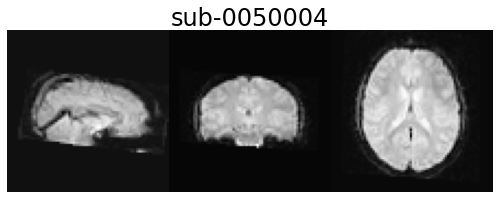

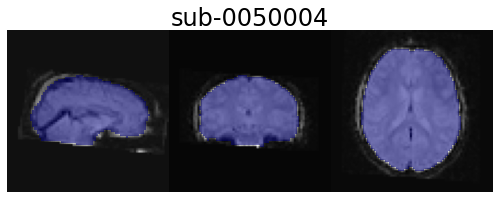

In [99]:
data['epi3d'].plot_ortho(flat=True,xyz_lines=False,orient_labels=False,title=sub)
data['epi3d'].plot_ortho(data['mask'],flat=True,xyz_lines=False,orient_labels=False,overlay_alpha=.5,title=sub)

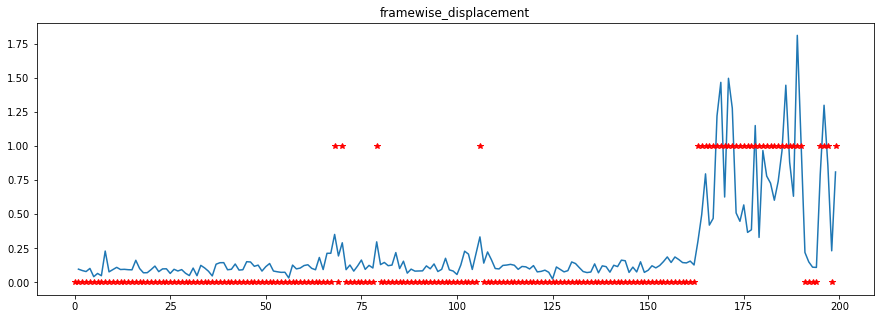

In [101]:
plt.figure(figsize=(15,5))
FD = data['conf']['framewise_displacement'].values
plt.plot(FD)
plt.plot(FD>.25,'r*')
plt.title('framewise_displacement');

In [115]:
scan_time_1 = data['epi'].shape[-1]*data['tr']/60
scan_time_2 = (FD<.25).sum()*data['tr']/60
print(f'scan time {scan_time_1} minutes before scrubbing')
print(f'scan time {scan_time_2} minutes after scrubbing')

scan time 5.0 minutes before scrubbing
scan time 4.075 minutes after scrubbing


In [102]:
thresh = .25 # FD treshold

scrub_idx = data['conf']['framewise_displacement'].values > thresh
epi_scrubbed = data['epi'].numpy()[:,:,:,~scrub_idx]

mat = epi_scrubbed.reshape(-1,epi_scrubbed.shape[-1]).transpose()
scrubbed_nii = make_4depi(mat,data['epi'])

rmat = regress(mat,data['conf'].iloc[~scrub_idx])

rmat_nii = make_4depi(rmat,data['epi'])
rmat_nii[data['mask'].numpy()==0]=0

In [103]:
rfmat_nii = filt(im=rmat_nii,
     tr=data['tr'],
     lowf=.01,
     highf=.1,
     order=3)

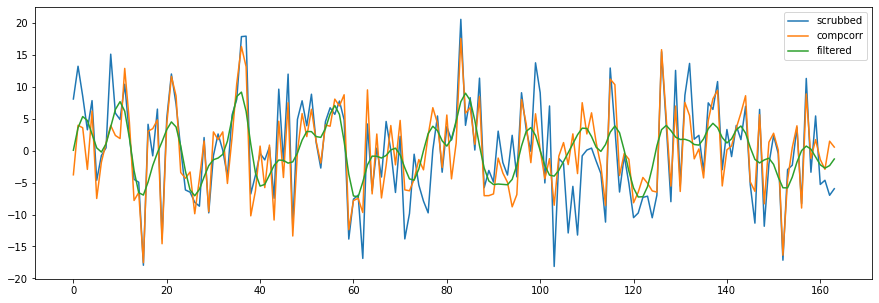

In [104]:
plt.figure(figsize=(15,5))
plt.plot(epi_scrubbed[48,26,26,:]-epi_scrubbed[48,26,26,:].mean())
plt.plot(rmat_nii.numpy()[48,26,26,:])
plt.plot(rfmat_nii.numpy()[48,26,26,:])
plt.legend(['scrubbed','compcorr','filtered']);

In [105]:
srfmat_nii = ants.smooth_image(image=rfmat_nii,sigma=4,sigma_in_physical_coordinates=True,FWHM=True,max_kernel_width=32)

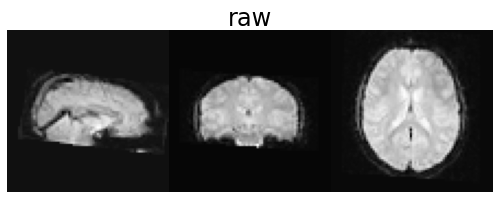

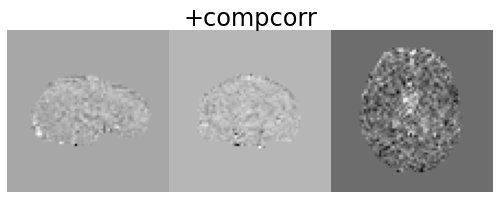

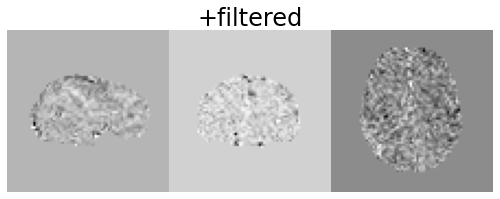

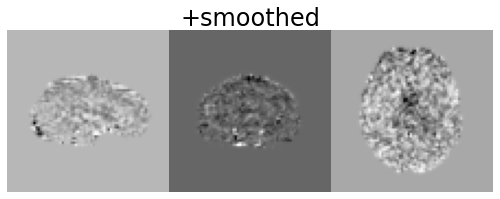

In [106]:
plot4d(data['epi'],title='raw')
plot4d(rmat_nii,title='+compcorr')
plot4d(rfmat_nii,title='+filtered')
plot4d(srfmat_nii,title='+smoothed')

In [107]:
ofdir = os.path.join(os.getenv("HOME"),'data/ABIDE/Derivatives/preprocessed')

In [108]:
subdir = os.path.join(ofdir,sub)

In [109]:
if not os.path.exists(subdir):
    os.mkdir(subdir)

In [110]:
data['epi'].to_filename(os.path.join(subdir,f'raw-{sub}_bold.nii.gz'))
data['mask'].to_filename(os.path.join(subdir,f'mask-{sub}_bold.nii.gz'))
rmat_nii.to_filename(os.path.join(subdir,f'rc-{sub}_bold.nii.gz'))
rfmat_nii.to_filename(os.path.join(subdir,f'frc-{sub}_bold.nii.gz'))
srfmat_nii.to_filename(os.path.join(subdir,f'sfrc-{sub}_bold.nii.gz'))

In [111]:
data['conf'].to_csv(os.path.join(subdir,f'conf-{sub}.csv'))

In [123]:

print(f'Duration: {now()-t0}')

Duration: 0:00:47.640804
